In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sqlalchemy import create_engine

In [2]:
ipaddress = '168.119.252.246'
port = '5432'
username = 'intern'
password = 'intern123'
dbname = 'wazzup_data_mart'

engine = create_engine(f'postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}')

<div class="alert alert-block alert-info">
<h1>Тестовое задание</h1>
</div>

### БД postgresql  
#### Таблица оплат "test_task_billing":

поле object нас интересуют значения
- channel - дневные списания
- package - списания за подписку
- payment - пополнение счета
- refund - возврат, когда клиенту сделали возврат его средств по той или иной причине
- unsubscribe - возврат за отмененую подписку

<div>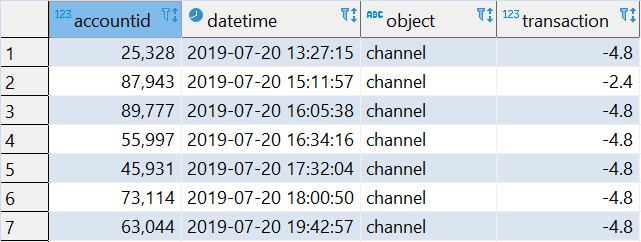</div>

#### Таблица партнеров "test_task_partner_acc":

- "partnerId" Имя партнера
- "accountId" Аккаунт партнера

<div>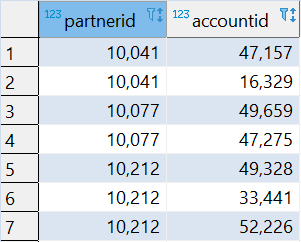</div>

<br>
Вначале взглянем на интересующие нас значения в агрегированном виде:
<br>
<br>
<div>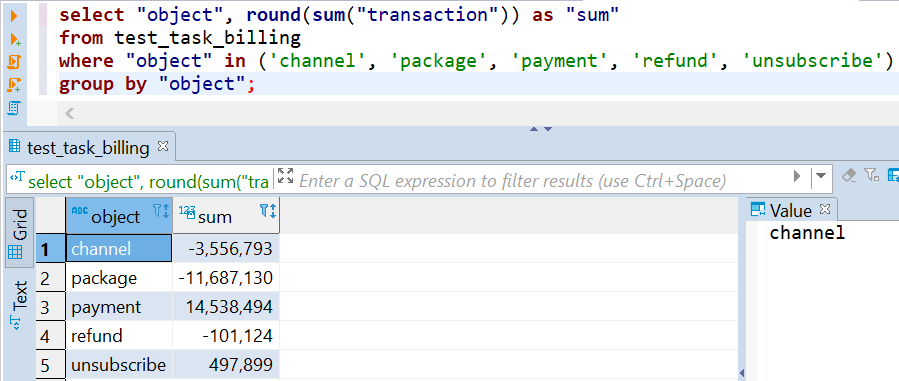</div>

Здесь конечно нужно уточнить значения терминов и формулы их расчета, но в рамках задания будем исходить из следующего:<br>
Знак означает изменение счета клиента: [+] увеличение счета, [-] уменьшение счета.<br><br>
Выручка = дневные списания + списания за подписку - возврат за отмененую подписку, т.е формула будет такая:<br>
**revenue = - sum(channel, package, unsubscribe)** <br><br>
Сумма пополнений = пополнение счета - возврат:<br>
**payment_total = sum(payment, refund)**

<div class="alert alert-success">
<h2> 1. Посчитать выручку за каждый месяц (SQL, решение в блокноте)</h2>
</div>

In [3]:
revenue_by_month_sql_query = '''
SELECT EXTRACT(YEAR FROM "datetime")::int8 AS "year",
       EXTRACT(MONTH FROM "datetime")::int8 AS "month",
      -ROUND(SUM("transaction")::numeric, 2) AS "revenue"
FROM test_task_billing
WHERE "object" IN ('channel', 'package', 'unsubscribe')
GROUP BY "year", "month";
'''

In [4]:
revenue_by_month_df = pd.read_sql_query(revenue_by_month_sql_query, engine)

In [5]:
revenue_by_month_df.tail(10)

,year,month,revenue
30,2020,7,724202.26
31,2020,8,730394.57
32,2020,9,861816.02
33,2020,10,1061405.57
34,2020,11,1068714.07
35,2020,12,1918214.35
36,2021,1,1104720.89
37,2021,2,1218600.36
38,2021,3,1464728.38
39,2021,4,34793.04


<div class="alert alert-success">
<h2> 2. Посчитать сумму пополнений клиентов партнеров по годам и какой это процент от общей выручки в этот же год (SQL, решение в блокноте)</h2>
<br>
Поля: год, партнер, выручка, процент от общей выручки по всем клиентам в этот год.
</div>

В перечне итоговых полей указана 'выручка', хотя в самом задании 'сумма пополнений'.<br>
Посчитаем именно суммы пополнений и их долю в общей выручке по годам.

In [6]:
payments_by_partners_by_years_sql_query = '''
SELECT "year", 
       "partnerid", 
       "payment_total",
       "payment_total" * 100 / "total_revenue_by_year" AS "percentage_of_total_revenue"
FROM (
    SELECT *, SUM("revenue") OVER (PARTITION BY "year") AS "total_revenue_by_year"
    FROM (
        SELECT EXTRACT(YEAR FROM "datetime")::int8 AS "year", 
        "partnerid", 
        SUM("transaction") FILTER (WHERE "object" IN ('payment', 'refund')) AS "payment_total",
       -SUM("transaction") FILTER (WHERE "object" IN ('channel', 'package', 'unsubscribe')) AS "revenue"
        FROM test_task_billing b
        LEFT JOIN test_task_partner_acc pa ON b.accountid = pa.accountid 
        GROUP BY "year", "partnerid" 
        ORDER BY "year", "partnerid" 
    ) AS slc1
) AS slc2
WHERE "payment_total" NOTNULL;
'''

In [7]:
payments_by_partners_by_years_df = pd.read_sql_query(payments_by_partners_by_years_sql_query, engine)

In [8]:
payments_by_partners_by_years_df.tail(10)

,year,partnerid,payment_total,percentage_of_total_revenue
1675,2021,99044.0,1080.000,0.028251
1676,2021,99145.0,3249.600,0.085005
1677,2021,99234.0,37.200,0.000973
1678,2021,99270.0,540.000,0.014126
1679,2021,99509.0,3356.400,0.087799
1680,2021,99569.0,864.000,0.022601
1681,2021,99752.0,24.000,0.000628
1682,2021,99762.0,9660.000,0.252692
1683,2021,99945.0,2280.000,0.059641
1684,2021,NaN,2085331.752,54.549243


'**NaN**' в поле **partnerid** - это в сумме клиенты, которых нет в таблице **test_task_partner_acc**.

<div class="alert alert-success">
<h2>3.Постройте график выручки по месяцам (как удобней)</h2>
</div>

In [9]:
# добавим столбы для более удобной подписи периода и для выручки в миллионах

def get_month_year(row):
    months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
          7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    return months[row.month] + ' ' + str(row.year)[2:4]

revenue_by_month_df['month_year'] = revenue_by_month_df.apply(get_month_year, axis=1)
revenue_by_month_df['revenue_mln'] = revenue_by_month_df.revenue.apply(lambda revenue: round(revenue / 10**6, 2))

In [10]:
# также уберем данные за апрель 2021, т.к они не полные и будут влиять на восприятие графика

revenue_by_month_df = revenue_by_month_df.drop(revenue_by_month_df.tail(1).index)
revenue_by_month_df.tail()

,year,month,revenue,month_year,revenue_mln
34,2020,11,1068714.07,Nov 20,1.07
35,2020,12,1918214.35,Dec 20,1.92
36,2021,1,1104720.89,Jan 21,1.10
37,2021,2,1218600.36,Feb 21,1.22
38,2021,3,1464728.38,Mar 21,1.46


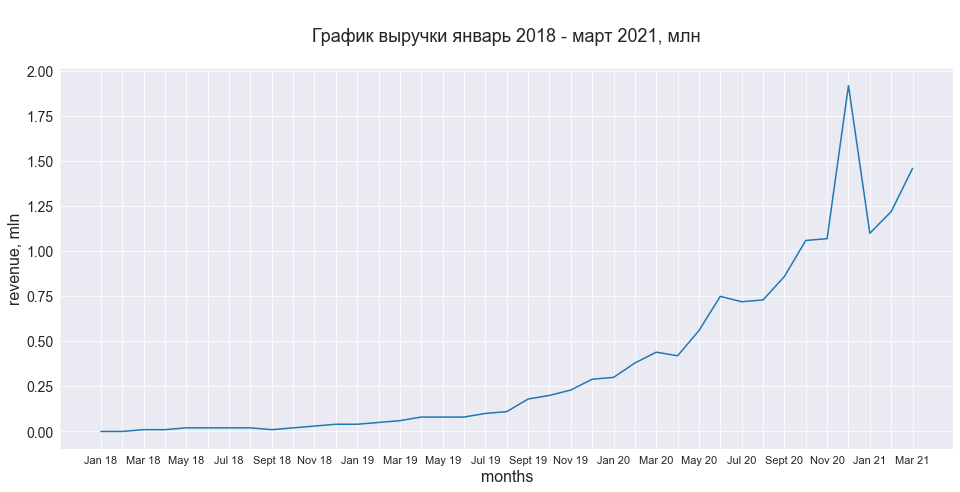

In [12]:
rcParams['figure.figsize'] = 16,7
plt.title("\nГрафик выручки январь 2018 - март 2021, млн\n", fontsize=18)
sns.set_style("darkgrid")
plt.xlabel("months", size=16)
plt.ylabel("revenue, mln", size=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=14)
plot = sns.lineplot(data=revenue_by_month_df, x='month_year', y='revenue_mln')

# разредим немного подписи оси x, чтобы не сливались
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 2 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)